### Import Anatomist (must be in a BrainVisa environment)

In [1]:
"""import anatomist.api as ana
from soma.qt_gui.qtThread import QtThreadCall
from soma.qt_gui.qt_backend import Qt

a = ana.Anatomist()

from soma import aims"""

'import anatomist.api as ana\nfrom soma.qt_gui.qtThread import QtThreadCall\nfrom soma.qt_gui.qt_backend import Qt\n\na = ana.Anatomist()\n\nfrom soma import aims'

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
import glob

In [2]:
base_path = "/volatile/ad279118/Irene/MOSTEST/Results/ChampollionV0"
#region_model = "SFint-FCMant_right/trained_on_UKB40/16-55-54_1"
region_model = "CINGULATE_right/09-52-22_75"


From the variable base_path, the files must then be ordered as:

```
SFint-FCMant_left
└── trained_on_UKB40
    └── 16-55-54_0
        ├── Correlation_Matrix_SNPs_MOSTest.eps
        ├── extracted_genotypes.raw
        ├── mostest_imputed_autosomes_decim_maf-0.05.most_orig.sumstats
        ├── mostest_imputed_autosomes_decim_maf-0.05_most_orig.zmat.tsv
        └── pheno_pre_residualized.txt
```

In [3]:
pre_residualized_bdd = pd.read_csv(f'{base_path}/{region_model}/pheno_pre_residualized.txt', sep='\t')
z_score = pd.read_csv(f'{base_path}/{region_model}/mostest_imputed_autosomes_decim_maf-0.05_most_orig.zmat.tsv', sep='\t')

pre_residualized_bdd = pre_residualized_bdd.drop('#FID', axis=1)
pre_residualized_bdd = pre_residualized_bdd.set_index('IID')

In [4]:
#path_to_lead_SNPs = glob.glob(f'{base_path}/{region_model}/FUMA_job*/leadSNPs.txt')[0]
#FUMA_lead_SNP = pd.read_csv(path_to_lead_SNPs, sep='\t', index_col=0)
#FUMA_lead_SNP

In [5]:
print(pre_residualized_bdd.shape)
pre_residualized_bdd = pre_residualized_bdd[[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]
pre_residualized_bdd.iloc[:,:5].head()

(36000, 41)


,dim1,dim2,dim3,dim4,dim5
IID,,,,,
1000021,-2.104199,-1.359375,-0.291757,-0.327406,-0.496205
1000325,-0.403647,1.927505,0.035274,0.152413,-1.666095
1000458,0.599884,-0.770553,-0.953452,0.002402,-1.154339
1000575,1.300538,0.262741,1.690291,-0.541938,0.738527
1000606,-0.707331,-2.032146,0.542180,-0.197312,-0.204915


### First approach using the Z-scores to find a direction in the latent space

In [6]:
print(z_score.shape)
z_score = z_score[['CHR','SNP','PVAL', 'N', 'FREQ']+[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]
z_score.iloc[:,:8].head()

(45, 46)


,CHR,SNP,PVAL,N,FREQ,dim1,dim2,dim3
0,1,rs10429880,2.340548e-08,41092.0,0.240473,0.648074,2.693549,-3.295873
1,1,rs10917498,2.584748e-09,41182.0,0.239595,0.571758,2.586241,-3.362413
2,1,rs7517255,2.584748e-09,41185.0,0.239456,0.571758,2.586241,-3.362413
3,1,rs2314329,2.663477e-09,41182.0,0.239607,0.570620,2.583678,-3.361125
4,1,rs12041062,7.519855e-09,41184.0,0.236840,0.749239,2.585691,-3.000783


In [7]:
def project(direction, latent=pre_residualized_bdd):
    # Compute the dot product of each row in pre_residualized_bdd with the direction
    dot_products = latent.apply(lambda row: np.dot(row, direction), axis=1)


    direction = np.dot(direction, direction)
    projections = dot_products / direction

    # Sort the series by the projection values
    sorted_projections = projections.sort_values(ascending=False)

    return sorted_projections

In [8]:
genotype = pd.read_csv(f'{base_path}/{region_model}/extracted_genotypes.raw', sep='\t')
genotype.head()

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs3020595_G,rs7636227_A,rs7728751_A,rs111328903_T
0,1000021,1000021,0,0,1,-9,0.0,1.0,1,2.0
1,1000325,1000325,0,0,1,-9,0.0,1.0,2,1.0
2,1000458,1000458,0,0,1,-9,0.0,2.0,2,1.0
3,1000575,1000575,0,0,1,-9,0.0,2.0,0,0.0
4,1000606,1000606,0,0,2,-9,1.0,2.0,1,1.0


In [9]:
genotype[['IID','SEX','rs3020595_G']].head()

,IID,SEX,rs3020595_G
0,1000021,1,0.0
1,1000325,1,0.0
2,1000458,1,0.0
3,1000575,1,0.0
4,1000606,2,1.0


In [14]:
sorted_projections_df

,projection
IID,
2516958,0.132141
4656488,0.131306
2324341,0.125248
4748953,0.122394
5374510,0.121120
...,...
5600200,-0.116112
1715213,-0.116868
5265453,-0.117407


In [16]:
def save_projection_file(SELECTED_SNP, sorted_projections_df, heuristic):
    """
    SELECTED_SNP: str
        for instance 'rs3020595_G' or 'rs3020595'

    sorted_projections_df: df
        ['IID', 'projection'] are the two columns
    """

    folder_path = f'{base_path}/{region_model}/Sorted_projection/{heuristic}'
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Define the full path to the CSV file
    csv_path = os.path.join(folder_path, f'{SELECTED_SNP}.csv')
    sorted_projections_df.set_index('IID', inplace=True)
    sorted_projections_df.to_csv(csv_path)

rs3020595_G 

R-squared (uncentered): 0.0024229534094062366
Prob (F-statistic): 0.00012935964120306138 

Number of subject with 0 allele G: 20269
Number of subject with 1 allele G: 12060
Number of subject with 2 allele G: 1715


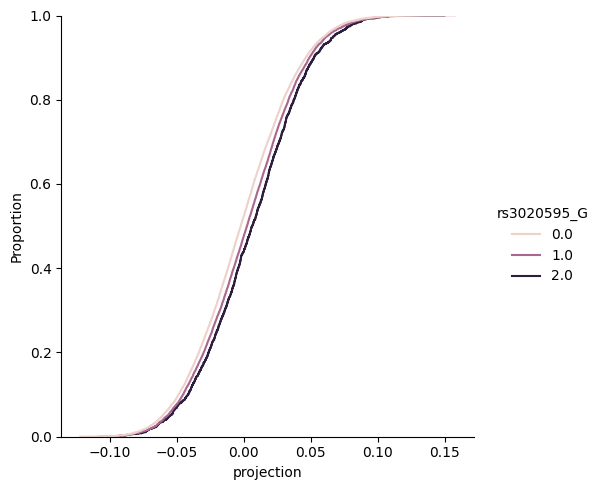

rs7636227_A 

R-squared (uncentered): 0.0010250748396587461
Prob (F-statistic): 0.737748562796081 

Number of subject with 0 allele A: 6851
Number of subject with 1 allele A: 16812
Number of subject with 2 allele A: 10381


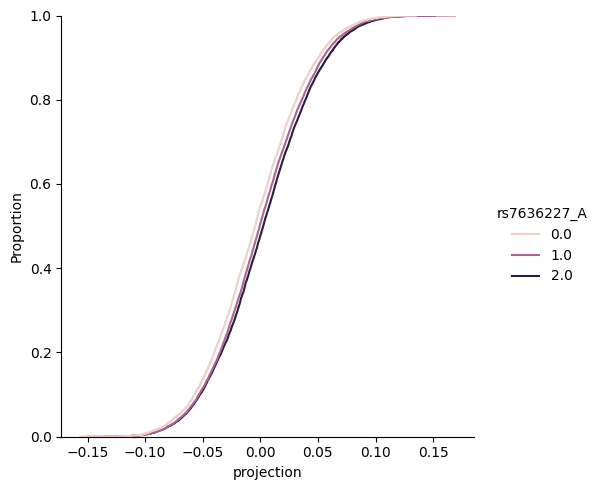

rs7728751_A 

R-squared (uncentered): 0.00047449749089789606
Prob (F-statistic): 0.9998253017866995 

Number of subject with 0 allele A: 1450
Number of subject with 1 allele A: 10946
Number of subject with 2 allele A: 21648


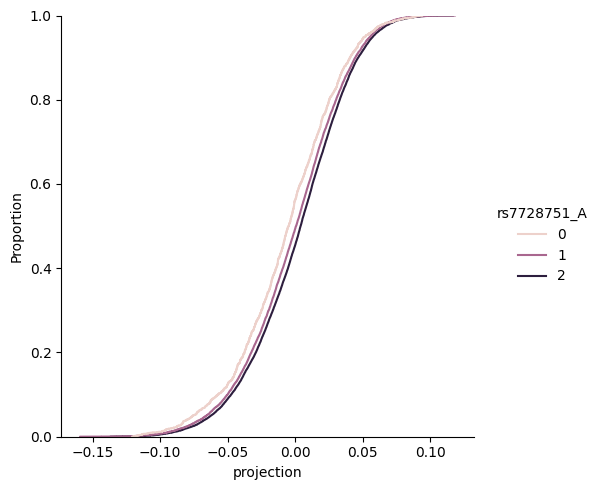

rs111328903_T 

R-squared (uncentered): 0.0016740276351607797
Prob (F-statistic): 0.04945331914062644 

Number of subject with 0 allele T: 16331
Number of subject with 1 allele T: 14498
Number of subject with 2 allele T: 3215


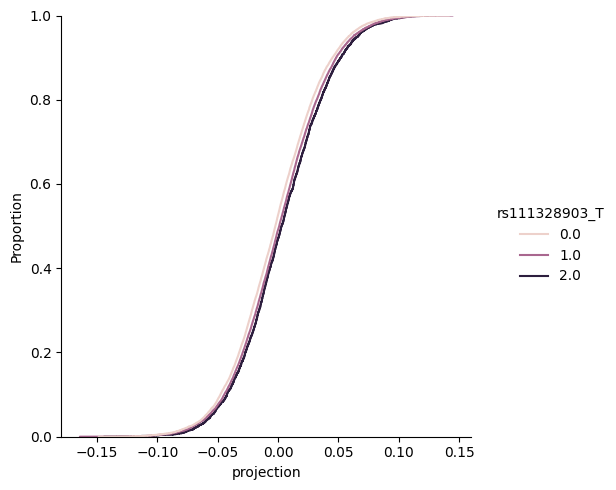

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax

heuristic = "regression_on_latent" #"direction_square_Z_score" "direction_soft_max" "direction_Z_score" "regression_on_latent"
depending_on_SEX = False
violin = False
density = True

    #for the regression
bdd_geno = pd.merge(pre_residualized_bdd, genotype, on='IID', how='inner')
bdd_geno = bdd_geno.dropna()

# Features (latent dimensions) and target (genotype)
X = bdd_geno[[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]  # Select all latent dimensions

#SELECTED_SNP = "rs10917502"
for SELECTED_SNP in genotype.drop(['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis=1).keys():
    print(SELECTED_SNP, "\n")
    speci_Z = z_score[z_score.SNP==SELECTED_SNP[:-2]][[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]

    
    if heuristic == "direction_square_Z_score":
        direction = np.sign(speci_Z)*speci_Z**2
    elif heuristic == "direction_soft_max":
        direction = np.sign(speci_Z)*softmax(speci_Z)
    elif heuristic == "regression_on_latent":
        y = bdd_geno[SELECTED_SNP]         # Genotype values (0, 1, or 2)

        mod = sm.OLS(y, X)
        res = mod.fit()
        #print(res.summary())
        print("R-squared (uncentered):", res.rsquared)
        print("Prob (F-statistic):", res.f_pvalue, "\n")
        merged = pd.DataFrame({"IID":bdd_geno.IID, SELECTED_SNP:y,"projection":res.predict()}).sort_values('projection')
        save_projection_file(SELECTED_SNP, merged[['IID', 'projection']], heuristic)

    else:
        heuristic = "direction_Z_score"
        direction = speci_Z

    if heuristic != "regression_on_latent":

        direction = direction.to_numpy().flatten()

        sorted_projections = project(direction, pre_residualized_bdd)
        sorted_projections.name = 'projection'
        sorted_projections_df = sorted_projections.reset_index()
        sorted_projections_df.columns = ['IID', 'projection']

        selected_columns = genotype.loc[:, genotype.columns.str.startswith(SELECTED_SNP)]
        rsids = [rsid for rsid in selected_columns.columns]
        reduced_genotype = genotype[['IID', 'SEX']+rsids]

        merged = pd.merge(sorted_projections, reduced_genotype, on='IID', how='inner')
        merged = merged.dropna()

        save_projection_file(SELECTED_SNP, sorted_projections_df, heuristic)

    #print("10 first extreme cases", "\n", merged.iloc[0:10], "\n")
    #print("10 last extreme cases", "\n",merged.iloc[-10:], "\n")
    print(f"Number of subject with 0 allele {SELECTED_SNP[-1]}:", len(merged[merged[SELECTED_SNP]==0]))
    print(f"Number of subject with 1 allele {SELECTED_SNP[-1]}:", len(merged[merged[SELECTED_SNP]==1]))
    print(f"Number of subject with 2 allele {SELECTED_SNP[-1]}:", len(merged[merged[SELECTED_SNP]==2]))
    
    if violin :
        if depending_on_SEX:

            geno_pheno_male = merged[merged.SEX==1]
            geno_pheno_female = merged[merged.SEX==2]

            plt.figure(figsize=(8, 6))
            sns.violinplot(x=rsids[0], y='projection', data=geno_pheno_male, hue=SELECTED_SNP)

            plt.xlabel('Number of G Alleles')
            plt.ylabel('Projection Value')
            plt.title(f'Violin Plot of Projection vs. Number of {SELECTED_SNP} Alleles for males')
            plt.legend(loc='upper right')
            plt.show()

            plt.figure(figsize=(8, 6))
            sns.violinplot(x=rsids[0], y='projection', data=geno_pheno_female, hue=SELECTED_SNP)

            plt.xlabel('Number of G Alleles')
            plt.ylabel('Projection Value')
            plt.title(f'Violin Plot of Projection vs. Number of {SELECTED_SNP} Alleles for females')
            plt.legend(loc='upper right')
            plt.show()

        else:          
            plt.figure(figsize=(8, 6))
            sns.violinplot(x=rsids[0], y='projection', data=merged, hue=SELECTED_SNP)

            plt.xlabel('Number of G Alleles')
            plt.ylabel('Projection Value')
            plt.title(f'Violin Plot of Projection vs. Number of {SELECTED_SNP} Alleles')
            plt.legend(loc='upper right')
            plt.show()
    
    if density:
        sns.displot(data=merged, x="projection", kind="ecdf", hue=SELECTED_SNP)
        plt.show()






 

### Second approach using a regression on the residualized phenotype based on the genotype

In [17]:
bdd_geno = pd.merge(pre_residualized_bdd, genotype, on='IID', how='inner')
bdd_geno = bdd_geno.dropna()
bdd_geno.head()

,IID,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim41,FID,PAT,MAT,SEX,PHENOTYPE,rs3020595_G,rs7636227_A,rs7728751_A,rs111328903_T
0,1000021,-2.104199,-1.359375,-0.291757,-0.327406,-0.496205,-0.722705,-0.532286,-0.028447,0.637746,...,1.852373,1000021,0,0,1,-9,0.0,1.0,1,2.0
1,1000325,-0.403647,1.927505,0.035274,0.152413,-1.666095,0.112163,0.143192,-0.861987,-0.241752,...,-0.950385,1000325,0,0,1,-9,0.0,1.0,2,1.0
2,1000458,0.599884,-0.770553,-0.953452,0.002402,-1.154339,-2.484531,-0.034020,0.441102,0.270100,...,0.018139,1000458,0,0,1,-9,0.0,2.0,2,1.0
3,1000575,1.300538,0.262741,1.690291,-0.541938,0.738527,0.641420,1.762575,0.033881,0.624490,...,-1.114975,1000575,0,0,1,-9,0.0,2.0,0,0.0
4,1000606,-0.707331,-2.032146,0.542180,-0.197312,-0.204915,1.765545,-0.495968,-0.870092,-0.212386,...,0.256188,1000606,0,0,2,-9,1.0,2.0,1,1.0


In [18]:
import statsmodels.api as sm

# Features (latent dimensions) and target (genotype)
X = bdd_geno[[f'dim{i}' for i in range(1,pre_residualized_bdd.shape[1]+1)]]  # Select all latent dimensions



rs3020595_G
R-squared (uncentered): 0.0024229534094062366
Prob (F-statistic): 0.00012935964120306138 



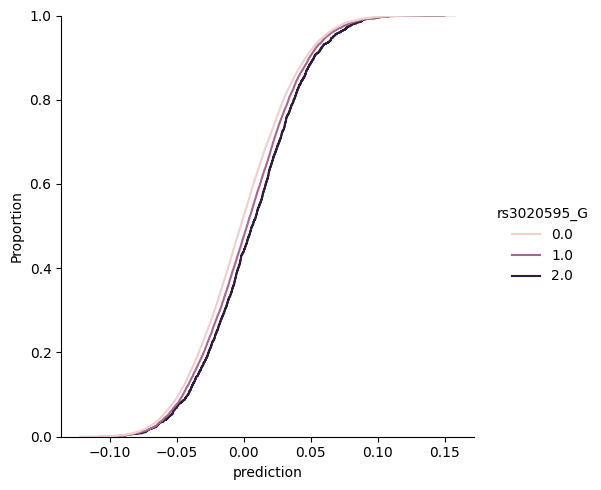

rs7636227_A
R-squared (uncentered): 0.0010250748396587461
Prob (F-statistic): 0.737748562796081 



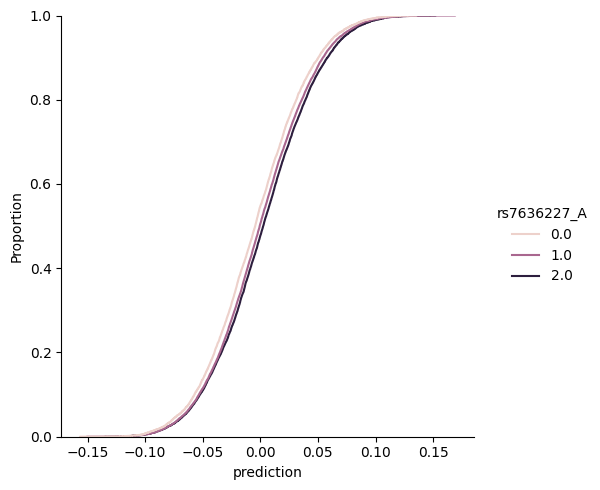

rs7728751_A
R-squared (uncentered): 0.00047449749089789606
Prob (F-statistic): 0.9998253017866995 



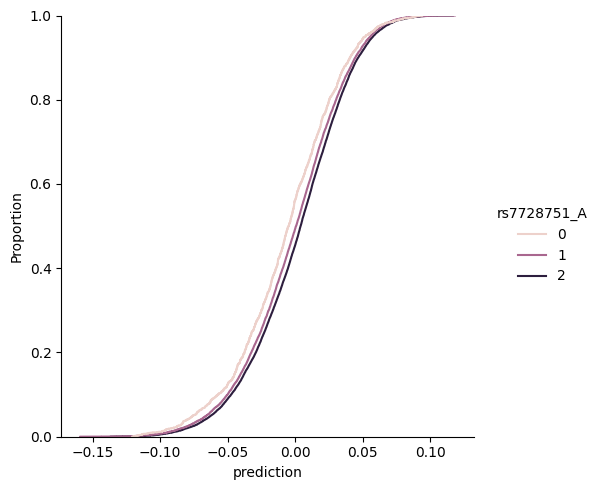

rs111328903_T
R-squared (uncentered): 0.0016740276351607797
Prob (F-statistic): 0.04945331914062644 



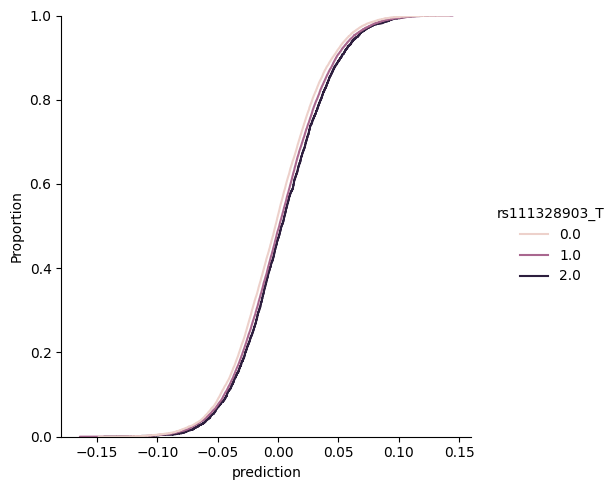

In [20]:
for key in bdd_geno.keys():
    if key.startswith('rs'):
        y = bdd_geno[key]         # Genotype values (0, 1, or 2)

        mod = sm.OLS(y, X)
        res = mod.fit()
        #print(res.summary())
        print(key)
        print("R-squared (uncentered):", res.rsquared)
        print("Prob (F-statistic):", res.f_pvalue, "\n")
        merged = pd.DataFrame({"IID":bdd_geno.IID, key:y,"prediction":res.predict()}).sort_values('prediction')
        
        if violin:
            plt.figure(figsize=(8, 6))
            sns.violinplot(x=key, y='prediction', data=merged, hue=key)

            plt.xlabel(f'Number of {key[-1]} Alleles')
            plt.ylabel('Prediction Value')
            plt.title(f'Violin Plot of Prediction vs. Number of {key} Alleles')
            plt.legend(loc='upper right')
            plt.show()
        if density:
            sns.displot(data=merged, x="prediction", kind="ecdf", hue=key)
            plt.show()



In [98]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            rs3874943_G   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.367
Date:                Fri, 20 Dec 2024   Prob (F-statistic):                      0.0588
Time:                        11:16:51   Log-Likelihood:                         -37744.
No. Observations:               22981   AIC:                                  7.557e+04
Df Residuals:                   22940   BIC:                                  7.590e+04
Df Model:                          41                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dim1          -0.0057      0.008     -0.688      0.492      -0.022       0.010
dim2           0.0253      0.008      3.042      0.002       0.009       0.042
dim3           0.0130      0.008      1.573      0.116      -0.003       0.029
dim4           0.0006      0.008      0.070      0.944      -0.016       0.017
dim5           0.0059      0.008      0.713      0.476      -0.010       0.022
dim6          -0.0041      0.008     -0.494      0.621      -0.020       0.012
dim7          -0.0065      0.008     -0.790      0.429      -0.023       0.010
dim8          -0.0100      0.008     -1.204      0.228      -0.026       0.006
dim9           0.0042      0.008      0.503      0.615      -0.012       0.020
dim10          0.0048      0.008      0.589      0.556      -0.011       0.021
dim11         -0.0042      0.008     -0.509      0.611      -0.020       0.012
dim12         -0.0159      0.008     -1.928      0.054      -0.032       0.000
dim13          0.0221      0.008      2.695      0.007       0.006       0.038
dim14          0.0027      0.008      0.324      0.746      -0.013       0.019
dim15         -0.0053      0.008     -0.639      0.523      -0.021       0.011
dim16         -0.0114      0.008     -1.377      0.169      -0.028       0.005
dim17          0.0035      0.008      0.427      0.670      -0.013       0.020
dim18         -0.0095      0.008     -1.155      0.248      -0.026       0.007
dim19          0.0051      0.008      0.615      0.538      -0.011       0.021
dim20         -0.0060      0.008     -0.722      0.471      -0.022       0.010
dim21         -0.0064      0.008     -0.774      0.439      -0.023       0.010
dim22          0.0009      0.008      0.113      0.910      -0.015       0.017
dim23         -0.0057      0.008     -0.692      0.489      -0.022       0.011
dim24          0.0060      0.008      0.724      0.469      -0.010       0.022
dim25          0.0095      0.008      1.157      0.247      -0.007       0.026
dim26          0.0050      0.008      0.605      0.545      -0.011       0.021
dim27          0.0158      0.008      1.916      0.055      -0.000       0.032
dim28         -0.0027      0.008     -0.325      0.745      -0.019       0.014
dim29          0.0089      0.008      1.077      0.282      -0.007       0.025
dim30          0.0056      0.008      0.672      0.501      -0.011       0.022
dim31         -0.0048      0.008     -0.581      0.562      -0.021       0.011
dim32         -0.0093      0.008     -1.124      0.261      -0.025       0.007
dim33         -0.0041      0.008     -0.498      0.618      -0.020       0.012
dim34          0.0113      0.008      1.373      0.170      -0.005       0.027
dim35         -0.0095      0.008     -1.149      0.251      -